# Representing bags in <tt><b>torchmil</b></tt>

In the following, we explain how <tt><b>torchmil</b></tt> represents bags and how to use them in your code. 

This notebook contains:

- A brief introduction to bags in Multiple Instance Learning (MIL). 
- How to represent bags in <tt><b>torchmil</b></tt>.
- A first look at the `ToyDataset` from the [<tt><b>torchmil.datasets</b></tt>](../api/datasets/index.md) module.
- How mini-batches are handled in <tt><b>torchmil</b></tt>.

## What is a bag?

In Multiple Instance Learning (MIL), a bag is a collection of instances. Usually, both instances and bags have labels. However, it is assumed that the labels of the instances in a bag are not available at training time. Instead, we only have access to:

- The label of the bag, 
- Some kind of relation between the instance labels and the bag label.

Additionally, a bag can have some structure, such as a graph representing the relationships between the instances in the bag, or the coordinates of the instances in some space.
All these cases can be handled with <tt><b>torchmil</b></tt>.

**Example: MIL binary classification.**
In this case, the bags have the form $\mathbf{X} = \left[ \mathbf{x}_1, \ldots, \mathbf{x}_N \right]^\top \in \mathbb{R}^{N \times D}$, where each $\mathbf{x}_n \in \mathbb{R}^D$ is an instance. 
The labels of the instances are $\mathbf{y} = \left[ y_1, \ldots, y_N \right]^\top \in \{0, 1\}^N$, but we do not have access to them at training time (they may be accessible at test time). The label of the bag is $Y \in \{0, 1\}$, and the relation between the instance labels and the bag label is as follows:

$$ Y = \max \left\{ y_1, \ldots, y_N \right\} $$

This example is the most common in MIL, but there are many other possibilities. 

## How bags are represented in torchmil?

In <tt><b>torchmil</b></tt>, bags are represented as a `TensorDict` object, which stores any kind of information about the bag. In most cases, a bag will contain at least the following keys:

- `bag['X']`: a tensor of shape `(bag_size, ...)` containing the instances in the bag. Usually, this tensor is called _bag feature matrix_, since these instances are feature vectors extracted from the raw representation of the instances, and therefore it has shape `(bag_size, feature_dim)`. 
- `bag['Y']`: a tensor containing the label of the bag. In the simplest case, this tensor is a scalar, but it can be a tensor of any shape (e.g., in multi-class MIL).

Additionally, a bag may contain other keys. The most common ones in <tt><b>torchmil</b></tt> are:

- `bag['y_inst']`: a tensor of shape `(bag_size, ...)` containing the labels of the instances in the bag. In the pure MIL setting, this tensor is only used for evaluation purposes since the label of the instances are not known. However, some methods may require some sort of supervision at the instance level.
- `bag['adj']`: a tensor of shape `(bag_size, bag_size)` containing the adjacency matrix of the bag. This matrix is used to represent the relationships between the instances in the bag. The methods implemented in [<tt><b>torchmil.models</b></tt>](../api/models/index.md) allow this matrix to be a sparse tensor.
- `bag['coords']`: a tensor of shape `(bag_size, coords_dim)` containing the coordinates of the instances in the bag. This tensor is used to represent the absolute position of the instances in the bag.

## Example: MNIST

Creating a bag is as simple as creating a `TensorDict` object.
Let's use the MNIST dataset to illustrate how bags are represented in <tt><b>torchmil</b></tt>.

In [1]:
import torch
from torchvision import datasets, transforms

# Load MNIST dataset
mnist = datasets.MNIST('/tmp/', train=True, download=True, transform=transforms.ToTensor())

# Extract features and labels
data = mnist.data.view(-1, 28*28) / 255
labels = mnist.targets

Let's create a bag of 10 instances. The label of each instance will be the digit it represents, and the label of the bag will be the maximum digit in the bag.

In [2]:
from tensordict import TensorDict

# Select 10 random indices
indices = torch.randperm(data.size(0))[:10]

bag = TensorDict({
    'X': data[indices],
    'y_inst': labels[indices],
    'Y': labels[indices].max()
})
bag

TensorDict(
    fields={
        X: Tensor(shape=torch.Size([10, 784]), device=cpu, dtype=torch.float32, is_shared=False),
        Y: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.int64, is_shared=False),
        y_inst: Tensor(shape=torch.Size([10]), device=cpu, dtype=torch.int64, is_shared=False)},
    batch_size=torch.Size([]),
    device=None,
    is_shared=False)

Now, let's create a MIL dataset using the `ToyDataset` class from [<tt><b>torchmil.datasets</b></tt>](../api/datasets/index.md).

We will create a binary dataset, where the digits $4$ and $5$ are the positive instances (their label is $1$), and the rest are the negative instances (their label is $0$). Thus, the label of the bag is $1$ if it contains at least one $4$ or $5$, and $0$ otherwise.

In [3]:
from torchmil.datasets import ToyDataset

# Define positive labels
obj_labels = [4, 5] # Digits 4 and 5 are considered positive

# Create MIL dataset
toy_dataset = ToyDataset(data, labels, num_bags=100, obj_labels=obj_labels, bag_size=10)

# Retrieve a bag
bag = toy_dataset[0]
bag

TensorDict(
    fields={
        X: Tensor(shape=torch.Size([10, 784]), device=cpu, dtype=torch.float32, is_shared=False),
        Y: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.int64, is_shared=False),
        y_inst: Tensor(shape=torch.Size([10]), device=cpu, dtype=torch.int64, is_shared=False)},
    batch_size=torch.Size([]),
    device=None,
    is_shared=False)

Let's visualize the bags

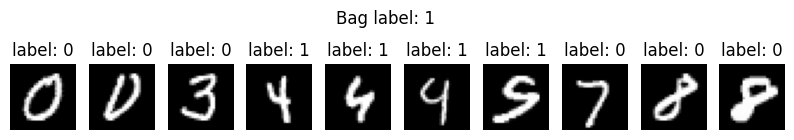

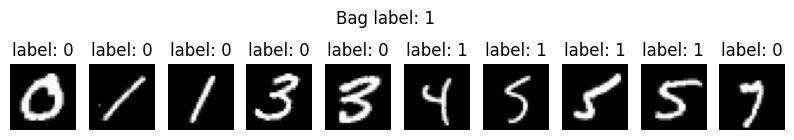

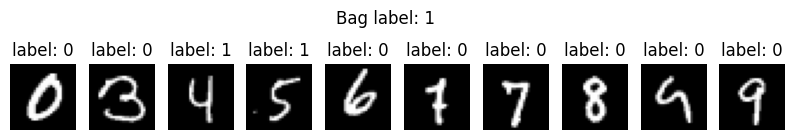

In [4]:
import matplotlib.pyplot as plt

def plot_bag(bag):
    bag_size = len(bag['X'])
    fig, axes = plt.subplots(1, bag_size, figsize=(bag_size, 1.8))
    for i in range(bag_size):
        ax = axes[i]
        ax.imshow(bag['X'][i].view(28, 28), cmap='gray')
        ax.set_title(f"label: {bag['y_inst'][i].item()}")        
        ax.axis('off')
    fig.suptitle(f'Bag label: {bag["Y"].item()}')
    plt.show()

for i in range(3):
    bag = toy_dataset[i]
    plot_bag(bag)

## Mini-batches in <tt><b>torchmil</b></tt>: the usage of masks

Mini-batches enable the training of deep learning models with huge amounts of data. In <tt><b>torchmil</b></tt>, mini-batches are handled by the `collate_fn` function of [<tt><b>torchmil.data</b></tt>](../api/data/index.md), which is used to collate a list of bags into a batch.

In MIL, each bag can be of different size. To solve this, in <tt><b>torchmil</b></tt>, the tensors in the bags are padded to the maximum size of the bags in the batch. A mask tensor is used to indicate which elements of the padded tensors are real instances and which are padding. This mask tensor is used to adjust the behavior of the models to ignore the padding elements (e.g., in the attention mechanism).

We illustrate this behaviour in the following example. We use again the MNIST dataset, but this time we create a dataset with bags of different sizes.

In [5]:
from torchmil.datasets import ToyDataset

# Define positive labels
obj_labels = [4, 5] # Digits 4 and 5 are considered positive

# Create MIL dataset
toy_dataset = ToyDataset(data, labels, num_bags=100, obj_labels=obj_labels, bag_size=(5, 8))

We retrieve four bags from the dataset and collate them into a batch. A batch is just a `TensorDict` object containing the padded tensors and the mask tensor.

In [6]:
from torchmil.data import collate_fn

bag_list = [toy_dataset[i] for i in range(4)]
batch = collate_fn(bag_list)
batch

TensorDict(
    fields={
        X: Tensor(shape=torch.Size([4, 7, 784]), device=cpu, dtype=torch.float32, is_shared=False),
        Y: Tensor(shape=torch.Size([4]), device=cpu, dtype=torch.int64, is_shared=False),
        mask: Tensor(shape=torch.Size([4, 7]), device=cpu, dtype=torch.uint8, is_shared=False),
        y_inst: Tensor(shape=torch.Size([4, 7]), device=cpu, dtype=torch.int64, is_shared=False)},
    batch_size=torch.Size([]),
    device=None,
    is_shared=False)

Let's plot the bags in the batch and the mask tensor.

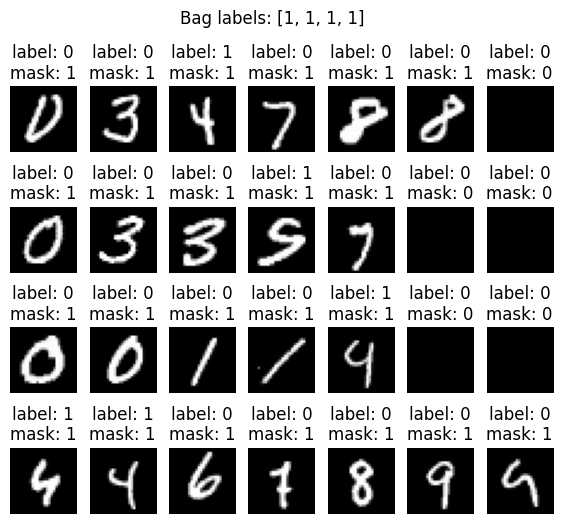

In [7]:
def plot_batch(batch):
    batch_size = len(batch['X'])
    bag_size = len(batch['X'][0])
    fig, axes = plt.subplots(batch_size, bag_size, figsize=(bag_size, 1.5*batch_size))
    for i in range(batch_size):
        for j in range(bag_size):
            ax = axes[i, j]
            ax.imshow(batch['X'][i][j].view(28, 28), cmap='gray')
            ax.set_title(f"label: {batch['y_inst'][i][j].item()}\nmask: {batch['mask'][i][j].item()}")        
            ax.axis('off')
        fig.suptitle(f'Bag labels: {batch["Y"].tolist()}')

plot_batch(batch)

As we can see, the bags are padded to the maximum size of the bags in the batch with zeros. The mask tensor indicates which elements are real instances and which are padding.